## ResNet 50 REVISED demo

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import logging
import numpy as np
import matplotlib.pyplot as plt
from pkg import c, m, f 

# classes 
paths = c.PathManager()
data = c.PeakImageDataset(paths)
prep = c.DataPreparation(paths, data, batch_size=5)
water_h5 = data.load_h5(paths.water_background_h5)
ip = c.ImageProcessor(water_h5)
p = c.PeakThresholdProcessor(threshold_value=10)

Number of peak images: 54
Number of water images: 54
Number of label images: 54


In [6]:
# if not already generated 
# ip.process_directory(paths, p.threshold_value, clen=0.1) 

In [7]:
# GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model
model = m.ResNet50BraggPeakClassifier()
# loss function/ combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Criterion: ", criterion)
print("Optimizer: \n", optimizer)
print("Learning rate: ", optimizer.param_groups[0]['lr'])
# data loaders 
train_loader, test_loader = prep.prep_data()

Using device: cpu
Criterion:  BCEWithLogitsLoss()
Optimizer: 
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate:  0.001
Data prepared.
Train size: 43
Test size: 11
Batch size: 5
Number of batches in train_loader: 9 




In [8]:
"""Training ResNet50BraggPeakClassifier model"""
num_epochs = 5
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
train_losses = test_losses = []

logging.info('Staring training...')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader: 
        peak_images, water_images = inputs[0].to(device), inputs[1].to(device)
        labels = labels.to(device)
        
        # zero parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(peak_images)
        loss = criterion(outputs, labels)
        # backward pass/optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # calculate accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted == labels).float().sum()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    logging.info(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss})')

2024-03-15 20:18:54,696 - INFO - Staring training...
2024-03-15 20:31:28,630 - INFO - Epoch [1/5], Loss: 0.26961904598606956, Accuracy: 3858813.75
2024-03-15 20:44:38,845 - INFO - Epoch [2/5], Loss: 0.10818875167104933, Accuracy: 4378454.5
2024-03-15 20:57:32,790 - INFO - Epoch [3/5], Loss: 0.10598913497394985, Accuracy: 4378454.5
2024-03-15 21:11:30,597 - INFO - Epoch [4/5], Loss: 0.1048412596186002, Accuracy: 4378454.5
2024-03-15 21:25:23,317 - INFO - Epoch [5/5], Loss: 0.10450258437130186, Accuracy: 4378454.5


In [9]:
"""Testing ResNet50BraggPeakClassifier model"""
logging.info('Starting testing...')
model.eval()  
test_loss = correct_peaks = total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        peak_images, water_images = inputs
        # forward pass prediction
        peak_pred = model(peak_images) 
        # compute loss
        loss = criterion(peak_pred, labels)
        test_loss += loss.item()
        # convert predictions to binary to compare with labels 
        peak_prediction = torch.sigmoid(peak_pred) > 0.5 
        # calculate accuracy of peak detection
        correct_peaks += (peak_prediction == labels).sum().item()
        total += np.prod(labels.shape) 

    avg_test_loss = test_loss / len(test_loader)
    peak_detection_accuracy = correct_peaks / total
    test_losses.append(avg_test_loss)
    # log results 
    logging.info(f"Test Loss: {avg_test_loss:.4f}, Bragg Peak Detection Accuracy: {peak_detection_accuracy:.4f}")
    logging.info(f'Test loss: {test_loss}')
    
logging.info('Testing completed.')

2024-03-15 21:25:23,593 - INFO - Starting testing...


2024-03-15 21:26:16,593 - INFO - Test Loss: 0.1123, Bragg Peak Detection Accuracy: 0.9730
2024-03-15 21:26:16,594 - INFO - Test loss: 0.33686790615320206
2024-03-15 21:26:16,596 - INFO - Testing completed.


In [10]:
len(train_losses)
# len(test_losses)

6

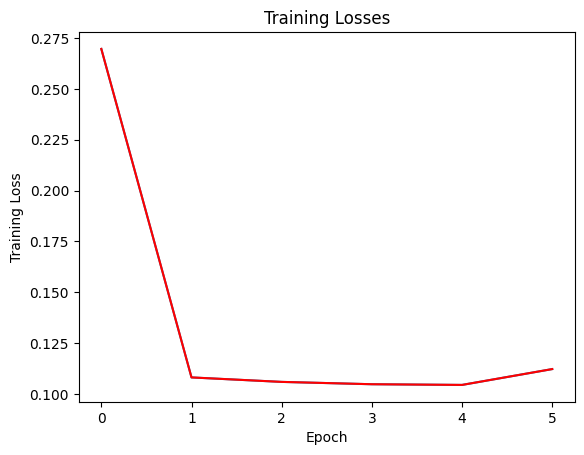

In [11]:
plt.plot(train_losses)
plt.plot(test_losses, color='r')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Losses')
plt.show()

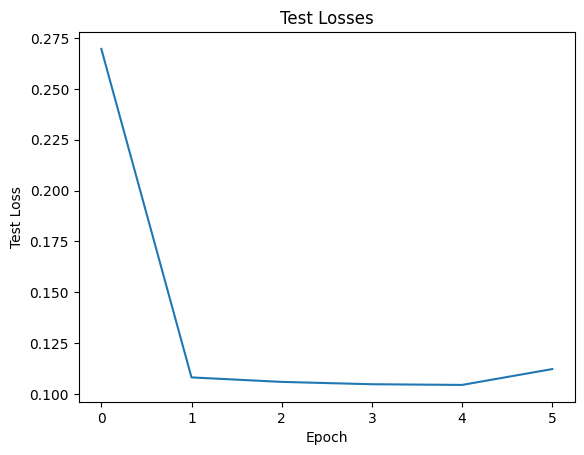

In [12]:
import matplotlib.pyplot as plt

plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Losses')
plt.show()
